<a href="https://colab.research.google.com/github/cristopher-d-delgado/image_classification_pneumonia/blob/main/mlp_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia Detection on Chest X-Rays

In [11]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

# Explore our Data & Preprocess

In [12]:
import os
# Create a path to the root folder and path to specific folders on my computer
data_path = "data/CellData/chest_xray/"

# Specificy paths for train, test, val
train_folder = os.path.join(data_path, 'train/')
test_folder = os.path.join(data_path, 'test/')
val_folder = os.path.join(data_path, 'validation/')

# Specify paths for labels
train_normal = os.path.join(train_folder, 'NORMAL')
train_pneumonia = os.path.join(train_folder, 'PNEUMONIA')
test_normal = os.path.join(test_folder, "NORMAL")
test_pneumonia = os.path.join(test_folder, "PNEUMONIA")
val_normal = os.path.join(val_folder, "NORMAL")
val_pneumonia = os.path.join(val_folder, "PNEUMONIA")

In [13]:
from PIL import Image

def detect_image_mode(image_path):
    # Open the image using PIL
    image = Image.open(image_path)

    # Check the number of channels
    num_channels = image.mode

    if num_channels == 'L':
        return "Black and White (Grayscale)"
    elif num_channels == 'RGB':
        return "Color (RGB)"
    else:
        return "Unknown"

# Example usage
image_path = r"data\CellData\chest_xray\train\NORMAL\NORMAL-32326-0001.jpeg"
image_mode = detect_image_mode(image_path)
print(f"The image is in {image_mode} mode.")

The image is in Black and White (Grayscale) mode.


It seems that our images are actually greyscale meaning they have have 1 channel rather than 3 channels unlike RGB images. [reference pillow docs](https://pillow.readthedocs.io/en/stable/handbook/concepts.html)

In [14]:
print('There are', len(os.listdir(train_normal)), 'normal images in the training set')
print('There are', len(os.listdir(train_pneumonia)), 'pneumonia images in the training set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(test_normal)), 'normal images in the testing set')
print('There are', len(os.listdir(test_pneumonia)), 'pneumonia images in the testing set')
print("________________________________________________________________________________________")
print('There are', len(os.listdir(val_normal)), 'normal images in the validation set')
print('There are', len(os.listdir(val_pneumonia)), 'pneumonia images in the validation set')

There are 1080 normal images in the training set
There are 3108 pneumonia images in the training set
________________________________________________________________________________________
There are 235 normal images in the testing set
There are 390 pneumonia images in the testing set
________________________________________________________________________________________
There are 269 normal images in the validation set
There are 776 pneumonia images in the validation set


Lets preprocess the images by resizing to (256, 256, 2)

In [15]:
from functions import process_data

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

# Preprocess data with our function
train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 4187 images belonging to 2 classes.


Found 624 images belonging to 2 classes.
Found 1045 images belonging to 2 classes.


It seems the generators are working as expected. The main downside is that the image genertaor does not let us know what images are normal and pneumonia but its labeled for us as 1, 0. Lets take a batch of images and see what we see so we know what is Normal and Peneumonia.

Image dimensions: (256, 256, 3)


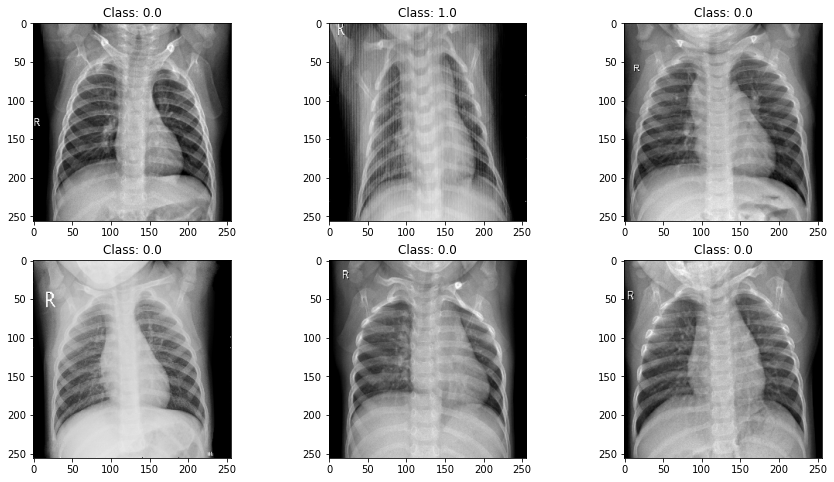

In [16]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {labels[0]}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {labels[1]}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {labels[2]}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {labels[3]}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {labels[4]}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {labels[5]}")

plt.show()

It seems images that arer very cloudy in the chest are Pneumonia while normal images are very clear. This means 1 is Pneumonia and 0 is Normal.

Image dimensions: (256, 256, 3)


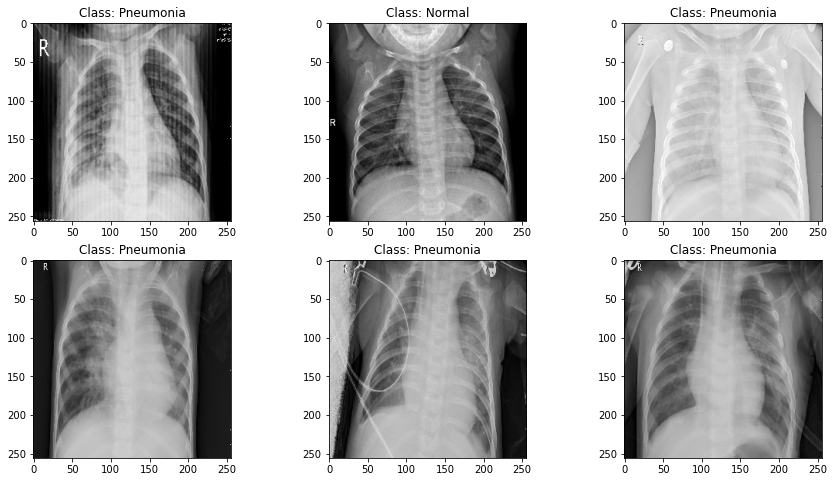

In [17]:
# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, figsize=(15, 8))

ax[0, 0].imshow(images[0])
ax[0, 0].set_title(f"Class: {'Normal' if labels[0] == 0 else 'Pneumonia'}")

ax[0, 1].imshow(images[1])
ax[0, 1].set_title(f"Class: {'Normal' if labels[1] == 0 else 'Pneumonia'}")

ax[0, 2].imshow(images[2])
ax[0, 2].set_title(f"Class: {'Normal' if labels[2] == 0 else 'Pneumonia'}")

ax[1, 0].imshow(images[3])
ax[1, 0].set_title(f"Class: {'Normal' if labels[3] == 0 else 'Pneumonia'}")

ax[1, 1].imshow(images[4])
ax[1, 1].set_title(f"Class: {'Normal' if labels[4] == 0 else 'Pneumonia'}")

ax[1, 2].imshow(images[5])
ax[1, 2].set_title(f"Class: {'Normal' if labels[5] == 0 else 'Pneumonia'}")

plt.show()


We sucecssfully resized the images and also created an RGB tensor. Lets create our datasets

# Make an Multilayer Perceptrons Model

I don't expect great perfomance in comparison to a Convuluted Neural Network. For the sake of trying we should attempt a basic neural network before getting more complex using basic MLP layers

**Base MLP Model:**

Define Base Model

We can attempt to train the model by iterating over the numebr of epochs. We can then save look at the validation and training loss and see where it begins to overfit.

In [18]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log
METRICS = metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy


# Define input shape
input_shape = (256, 256, 1)

# Define the basic model 
model_mlp_base = Sequential()

# Define the layers 
# Flatten layer to reshape the output
model_mlp_base.add(Flatten(input_shape=input_shape))
model_mlp_base.add(Dense(32, activation='relu'))

# Define the output 
model_mlp_base.add(Dense(1, activation='sigmoid'))


model_mlp_base.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 65536)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                2097184   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 2,097,217
Trainable params: 2,097,217
Non-trainable params: 0
_________________________________________________________________
None


In [22]:
from functions import train_model, view_history, model_evaluate

mlp = {}

# Train the model
mlp['Version1'] = train_model(model_mlp_base, train_gen, total_epochs=15)

# View History 
view_history(mlp, 'Version1')

# Evaluate model
model_evaluate(model_mlp_base, train_gen, test_gen, val_gen)

TypeError: train_model() missing 1 required positional argument: 'val_generator'

Our Train is very high at the beginning. Maybe the learning rate is too high so lets manually lower it. 

# MLP Version 2

In [12]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_2 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_2.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_2.add(Dense(32, activation='relu'))

# Define output layer
model_mlp_base_2.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_2.compile(optimizer=Adam(learning_rate=0.00001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_2.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                6291488   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,291,521
Trainable params: 6,291,521
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
131/131 [==============================] - 35s 267ms/step - loss: 0.4528 - precision: 0.7949 - recall: 0.9938 - accuracy: 0.7662 - val_loss: 0.3600 - val_precision: 0.8368 - val_recall: 0.9974 - val_accuracy: 0.8536
Epoch 2/15
131/131 [==============================] - 35s 269ms/step - loss: 0.3485 - precision: 0.8302 - recall: 0.9958 - accuracy: 0.8457 - val_loss: 0.3172 - val_precision: 0.8236 - val_recall: 0.9987 - val_accuracy: 0.8402
Epoch 3/15
131/131 [==============================] - 35s 265ms/step - loss: 0.3163 - precision: 0.8561 - recall: 0.9936 - accuracy: 0.8713 - val_loss: 0.2953 - val_precision: 0.8754 - val_recall: 0.9961 - val_accuracy: 0.8919
Epoch 4/15
131/131 [==============================] - 34s 263ms/step - loss: 0.2989 - precision: 0.8749 - recall: 0.9929 - accuracy: 0.8894 - val_loss: 0.2839 - val_precision: 0.8697 - val_recall: 0.9974 - val_accuracy: 0.8871
Epoch 5/15
131/131 [==============================] - 34s 263ms/step - loss: 0.2873 - precis

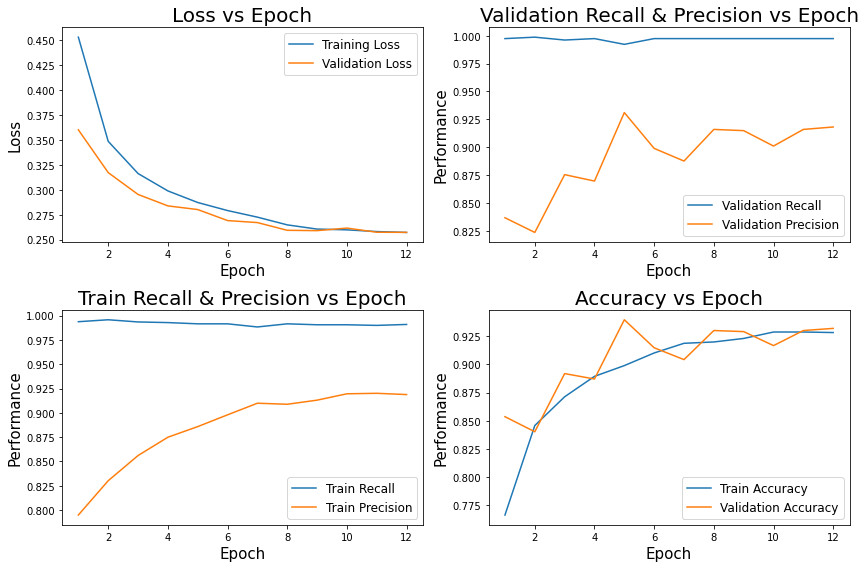

33/33 [==============================] - 6s 195ms/step - loss: 0.2591 - precision: 0.9149 - recall: 0.9974 - accuracy: 0.9292


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.258989,91.451472,99.163181,92.500597
1,Test,0.520569,72.607881,99.230766,76.121795
2,Validation,0.259069,91.489363,99.742270,92.918658


In [13]:
from functions import train_model, view_history, model_evaluate

# Update our dictionary with Version 2
mlp['Version2'] = train_model(model_mlp_base_2, train_gen, val_gen, total_epochs=15)

# View History
view_history(mlp, 'Version2')

# Evaluate model
model_evaluate(model_mlp_base_2, train_gen, test_gen, val_gen)

It seems that more neurons made generalize better. That means we can increase the neurons more since we are still generally still decreasing together.

# MLP Version 3

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_3 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_3.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_3.add(Dense(32, activation='relu'))

# Define output layer
model_mlp_base_3.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_3.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                6291488   
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 6,291,521
Trainable params: 6,291,521
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
131/131 [==============================] - 35s 267ms/step - loss: 0.4671 - precision: 0.7987 - recall: 0.9964 - accuracy: 0.7815 - val_loss: 0.3483 - val_precision: 0.8649 - val_recall: 0.9897 - val_accuracy: 0.8775
Epoch 2/15
131/131 [==============================] - 34s 262ms/step - loss: 0.3229 - precision: 0.8717 - recall: 0.9771 - accuracy: 0.8763 - val_loss: 0.2693 - val_precision: 0.9097 - val_recall: 0.9871 - val_accuracy: 0.9177
Epoch 3/15
131/131 [==============================] - 34s 261ms/step - loss: 0.2661 - precision: 0.9097 - recall: 0.9723 - accuracy: 0.9078 - val_loss: 0.2289 - val_precision: 0.9371 - val_recall: 0.9794 - val_accuracy: 0.9359
Epoch 4/15
131/131 [==============================] - 35s 265ms/step - loss: 0.2369 - precision: 0.9229 - recall: 0.9707 - accuracy: 0.9181 - val_loss: 0.2045 - val_precision: 0.9510 - val_recall: 0.9755 - val_accuracy: 0.9445
Epoch 5/15
131/131 [==============================] - 35s 266ms/step - loss: 0.2134 - precis

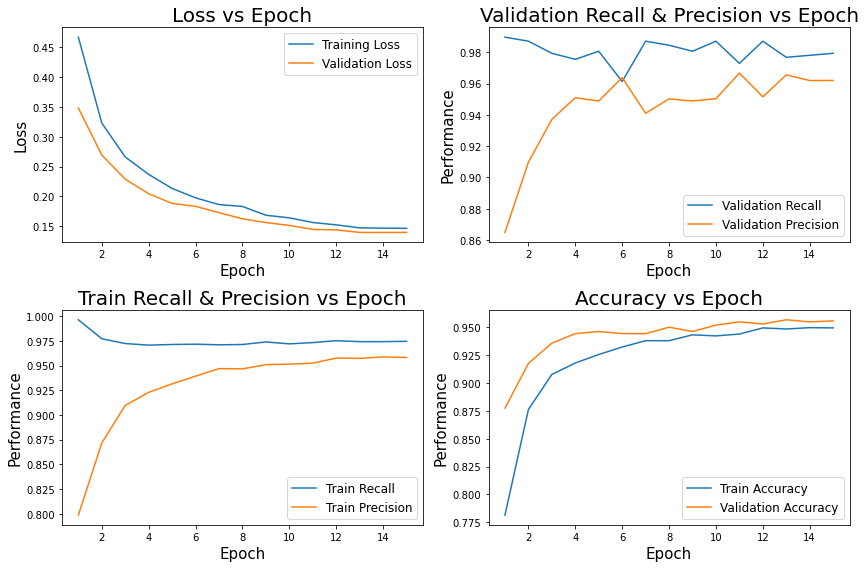

33/33 [==============================] - 7s 200ms/step - loss: 0.1397 - precision: 0.9620 - recall: 0.9794 - accuracy: 0.9560


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.146151,95.851803,97.425169,94.960594
1,Test,0.381909,78.732109,98.717946,82.532054
2,Validation,0.139670,96.202534,97.938144,95.598084


In [15]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 3
mlp['Version3'] = train_model(model_mlp_base_3, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version3')

# Evaluate model
model_evaluate(model_mlp_base_3, train_gen, test_gen, val_gen)

It seems we did better but not by much so perhaps we should add another layer to see if our metrics improve as well as loss. 

# MLP Version 4

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_4 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_4.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_4.add(Dense(16, activation='relu'))

# Define output layer
model_mlp_base_4.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_4.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_4.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                3145744   
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 17        
Total params: 3,145,761
Trainable params: 3,145,761
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
131/131 [==============================] - 35s 264ms/step - loss: 0.4847 - precision: 0.7874 - recall: 0.9951 - accuracy: 0.7573 - val_loss: 0.4052 - val_precision: 0.7717 - val_recall: 0.9974 - val_accuracy: 0.7789
Epoch 2/15
131/131 [==============================] - 34s 262ms/step - loss: 0.3758 - precision: 0.8319 - recall: 0.9894 - accuracy: 0.8438 - val_loss: 0.3443 - val_precision: 0.8054 - val_recall: 0.9974 - val_accuracy: 0.8191
Epoch 3/15
131/131 [==============================] - 35s 266ms/step - loss: 0.3199 - precision: 0.8718 - recall: 0.9826 - accuracy: 0.8799 - val_loss: 0.2885 - val_precision: 0.8880 - val_recall: 0.9910 - val_accuracy: 0.9005
Epoch 4/15
131/131 [==============================] - 35s 267ms/step - loss: 0.2901 - precision: 0.8937 - recall: 0.9765 - accuracy: 0.8963 - val_loss: 0.2600 - val_precision: 0.9312 - val_recall: 0.9768 - val_accuracy: 0.9292
Epoch 5/15
131/131 [==============================] - 35s 266ms/step - loss: 0.2631 - precis

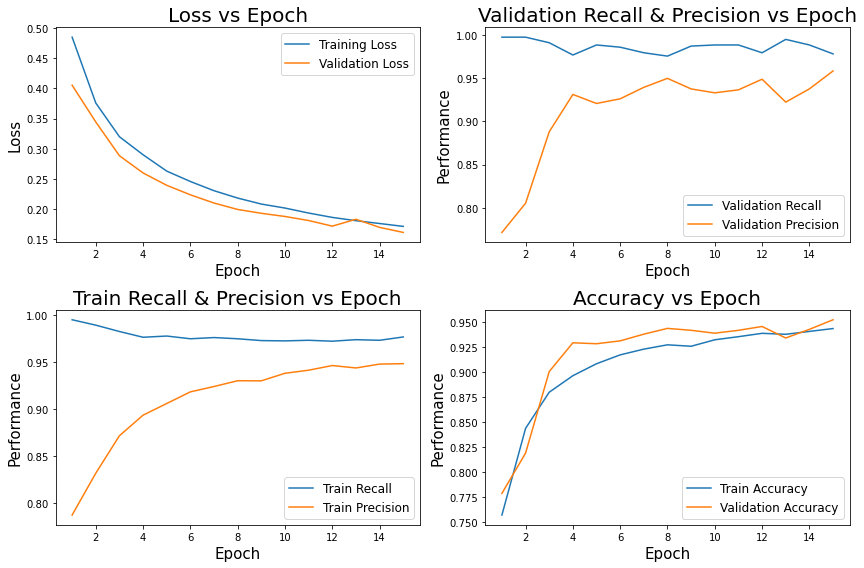

33/33 [==============================] - 7s 198ms/step - loss: 0.1616 - precision: 0.9583 - recall: 0.9781 - accuracy: 0.9522


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.170369,95.185649,97.360796,94.387388
1,Test,0.373522,79.132229,98.205125,82.692307
2,Validation,0.161579,95.833331,97.809279,95.215309


In [17]:
from functions import model_evaluate, view_history, train_model

# Update our dictionary with Version 4
mlp['Version4'] = train_model(model_mlp_base_4, train_gen, val_gen, total_epochs=15)

# View history 
view_history(mlp, 'Version4')

# Evaluate model
model_evaluate(model_mlp_base_4, train_gen, test_gen, val_gen)

It seems we can still generalize more by adding more neurons since the loss curves are still generally close together and decreasing with time. Lets add more neurons again

# MLP Version 5

In [18]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_5 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_5.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_5.add(Dense(16, activation='relu'))
model_mlp_base_5.add(Dropout(rate=.2, seed=42))

# Define output layer
model_mlp_base_5.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_5.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_5.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                3145744   
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 17        
Total params: 3,145,761
Trainable params: 3,145,761
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
131/131 [==============================] - 34s 263ms/step - loss: 0.5307 - precision: 0.7784 - recall: 0.9871 - accuracy: 0.7394 - val_loss: 0.4512 - val_precision: 0.7462 - val_recall: 1.0000 - val_accuracy: 0.7474
Epoch 2/15
131/131 [==============================] - 34s 261ms/step - loss: 0.4331 - precision: 0.7809 - recall: 0.9936 - accuracy: 0.7884 - val_loss: 0.3801 - val_precision: 0.7771 - val_recall: 0.9974 - val_accuracy: 0.7856
Epoch 3/15
131/131 [==============================] - 34s 257ms/step - loss: 0.3853 - precision: 0.8215 - recall: 0.9849 - accuracy: 0.8299 - val_loss: 0.3391 - val_precision: 0.8830 - val_recall: 0.9923 - val_accuracy: 0.8967
Epoch 4/15
131/131 [==============================] - 35s 264ms/step - loss: 0.3529 - precision: 0.8529 - recall: 0.9797 - accuracy: 0.8596 - val_loss: 0.3101 - val_precision: 0.9002 - val_recall: 0.9884 - val_accuracy: 0.9100
Epoch 5/15
131/131 [==============================] - 34s 262ms/step - loss: 0.3267 - precis

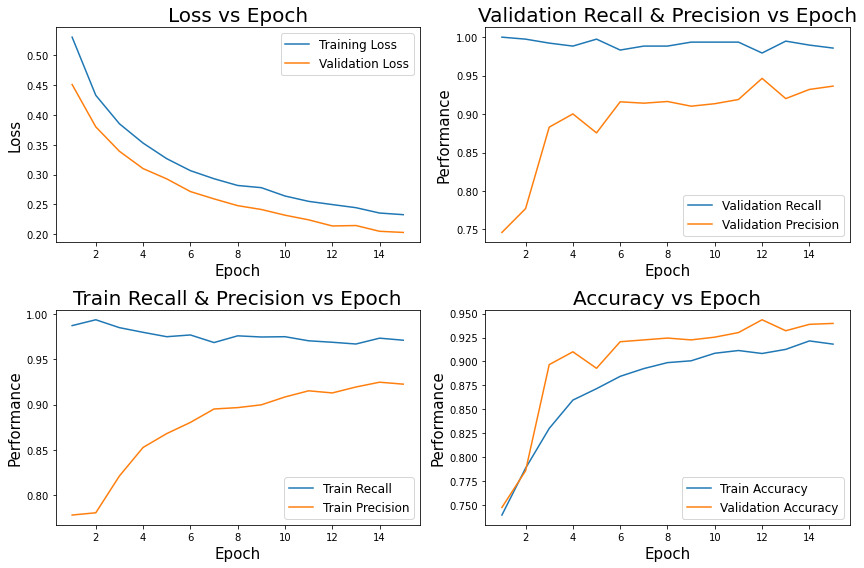

33/33 [==============================] - 6s 197ms/step - loss: 0.2029 - precision: 0.9364 - recall: 0.9858 - accuracy: 0.9397


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.211655,93.066585,98.068875,93.145448
1,Test,0.410709,76.633662,99.230766,80.608976
2,Validation,0.202916,93.635249,98.582476,93.971294


In [19]:
from functions import model_evaluate, train_model, view_history

# Train model and save history
mlp['Version5'] = train_model(model_mlp_base_5, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version5')

# Evaluate model 
model_evaluate(model_mlp_base_5, train_gen, test_gen, val_gen)

Now it seems that we had a bit of an overfit towards the end. It also seems as if it was going to go back to decreasing again with the train curve. Lets attempt more neurons on this second layer just to see what happens. This is also the first version where our test precision passes 80!

# MLP Version 6

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_6 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_6.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_6.add(Dense(64, activation='relu'))
model_mlp_base_6.add(Dropout(rate=0.20, seed=42))

# Define output layer
model_mlp_base_6.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_6.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_6.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_11 (Dense)             (None, 64)                12582976  
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 65        
Total params: 12,583,041
Trainable params: 12,583,041
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
131/131 [==============================] - 37s 281ms/step - loss: 0.4963 - precision: 0.7971 - recall: 0.9786 - accuracy: 0.7643 - val_loss: 0.3864 - val_precision: 0.7900 - val_recall: 0.9987 - val_accuracy: 0.8019
Epoch 2/15
131/131 [==============================] - 37s 280ms/step - loss: 0.3643 - precision: 0.8480 - recall: 0.9784 - accuracy: 0.8538 - val_loss: 0.3037 - val_precision: 0.8979 - val_recall: 0.9858 - val_accuracy: 0.9062
Epoch 3/15
131/131 [==============================] - 36s 278ms/step - loss: 0.3047 - precision: 0.8857 - recall: 0.9723 - accuracy: 0.8863 - val_loss: 0.2671 - val_precision: 0.8994 - val_recall: 0.9910 - val_accuracy: 0.9110
Epoch 4/15
131/131 [==============================] - 37s 280ms/step - loss: 0.2741 - precision: 0.9068 - recall: 0.9678 - accuracy: 0.9023 - val_loss: 0.2344 - val_precision: 0.9227 - val_recall: 0.9845 - val_accuracy: 0.9273
Epoch 5/15
131/131 [==============================] - 37s 284ms/step - loss: 0.2518 - precis

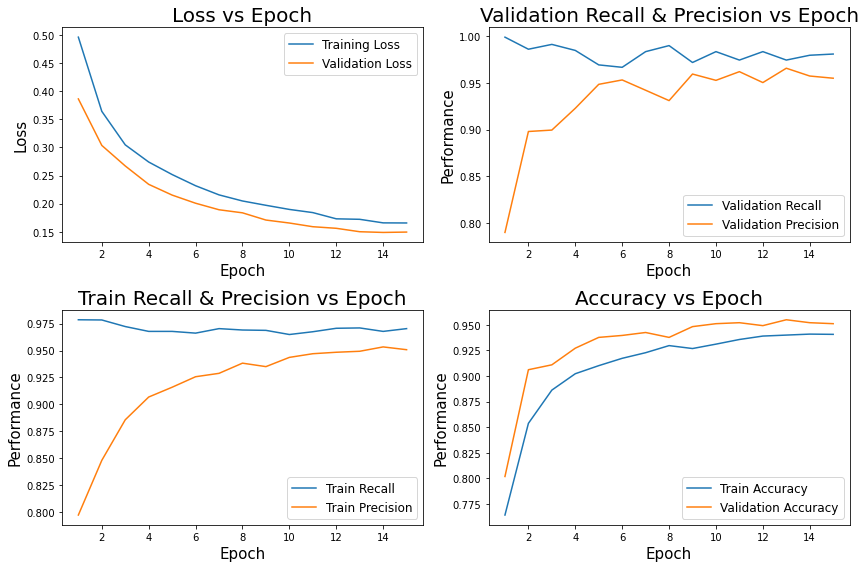

33/33 [==============================] - 7s 208ms/step - loss: 0.1495 - precision: 0.9548 - recall: 0.9807 - accuracy: 0.9512


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.155969,95.226133,97.586095,94.578457
1,Test,0.388366,78.893441,98.717946,82.692307
2,Validation,0.149489,95.483059,98.067009,95.119619


In [21]:
from functions import model_evaluate, view_history, train_model

# Train model
mlp['Version6'] = train_model(model_mlp_base_6, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, 'Version6')

# Evaluate model
model_evaluate(model_mlp_base_6, train_gen, test_gen, val_gen)

It seems we still do not overfit. No matter how many neurons we add we arent getting better metrics and we get very little loss improvement

# MLP version 7

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_7 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_7.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_7.add(Dense(256, activation='relu'))
model_mlp_base_7.add(Dense(256, activation='relu'))

# Define output layer
model_mlp_base_7.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_7.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_7.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               50331904  
_________________________________________________________________
dense_16 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 50,397,953
Trainable params: 50,397,953
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 43s 658ms/step - loss: 0.4310 - precision: 0.8181 - recall: 0.9918 - accuracy: 0.7991 - val_loss: 0.3201 - val_precision: 0.8771 - val_recall: 0.9936 - val_accuracy: 0.8919
Epoch 2/15
66/66 [==============================] - 45s 678ms/step - loss: 0.2942 - precision: 0.8909 - recall: 0.9775 - accuracy: 0.8944 - val_loss: 0.2513 - val_precision: 0.9006 - val_recall: 0.9923 - val_accuracy: 0.9129
Epoch 3/15
66/66 [==============================] - 43s 655ms/step - loss: 0.2521 - precision: 0.9096 - recall: 0.9656 - accuracy: 0.9033 - val_loss: 0.2132 - val_precision: 0.9253 - val_recall: 0.9897 - val_accuracy: 0.9330
Epoch 4/15
66/66 [==============================] - 42s 639ms/step - loss: 0.2168 - precision: 0.9333 - recall: 0.9678 - accuracy: 0.9248 - val_loss: 0.1955 - val_precision: 0.9254 - val_recall: 0.9910 - val_accuracy: 0.9340
Epoch 5/15
66/66 [==============================] - 43s 657ms/step - loss: 0.1960 - precision: 0.938

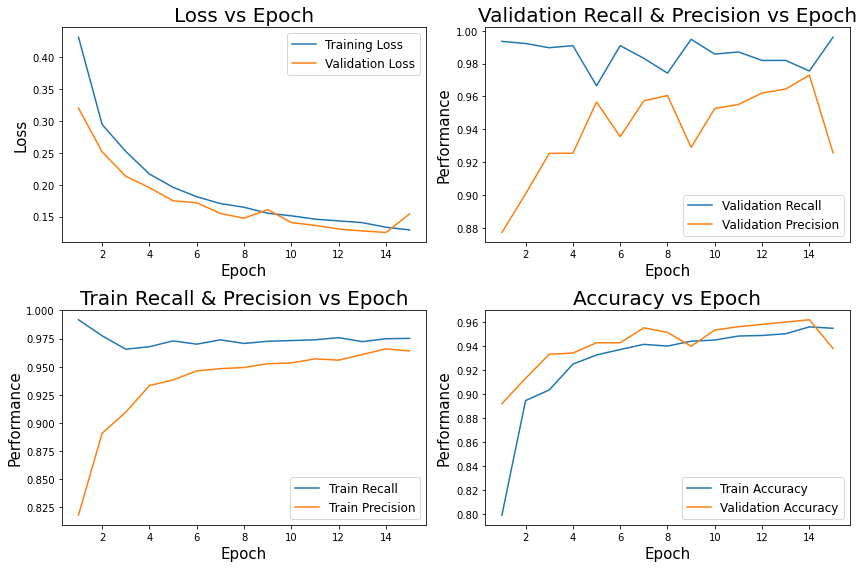

17/17 [==============================] - 7s 407ms/step - loss: 0.1544 - precision: 0.9257 - recall: 0.9961 - accuracy: 0.9378


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.149712,93.270689,99.034441,93.981373
1,Test,0.573822,73.244780,98.974359,76.762819
2,Validation,0.154445,92.574853,99.613404,93.779904


In [22]:
from functions import model_evaluate, train_model, view_history

# Train model
mlp['Version7'] = train_model(model_mlp_base_7, train_gen, val_gen, total_epochs=15)

# View History
view_history(mlp, 'Version7')

# Evaluate model
model_evaluate(model_mlp_base_7, train_gen, test_gen, val_gen)

Now it seems that we did overfit. Lets return to the previous version 6

# MLP Version 8

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
model_mlp_base_8 = Sequential()

# Define the layers 
# Flatten the input layer for the Dense layers
model_mlp_base_8.add(Flatten(input_shape=input_shape))

# Define our Dense Layers
model_mlp_base_8.add(Dense(256, activation='relu'))
model_mlp_base_8.add(Dense(192, activation='relu'))
model_mlp_base_8.add(Dense(64, activation='relu'))

# Define output layer
model_mlp_base_8.add(Dense(1, activation='sigmoid'))

# Compile the model
model_mlp_base_8.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(model_mlp_base_8.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 196608)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               50331904  
_________________________________________________________________
dense_19 (Dense)             (None, 192)               49344     
_________________________________________________________________
dense_20 (Dense)             (None, 64)                12352     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 65        
Total params: 50,393,665
Trainable params: 50,393,665
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 45s 681ms/step - loss: 0.4818 - precision: 0.7870 - recall: 0.9985 - accuracy: 0.7636 - val_loss: 0.3747 - val_precision: 0.8644 - val_recall: 0.9858 - val_accuracy: 0.8746
Epoch 2/15
66/66 [==============================] - 44s 665ms/step - loss: 0.3358 - precision: 0.8666 - recall: 0.9781 - accuracy: 0.8720 - val_loss: 0.2865 - val_precision: 0.8712 - val_recall: 0.9936 - val_accuracy: 0.8861
Epoch 3/15
66/66 [==============================] - 43s 645ms/step - loss: 0.2725 - precision: 0.8992 - recall: 0.9765 - accuracy: 0.9014 - val_loss: 0.2361 - val_precision: 0.9380 - val_recall: 0.9742 - val_accuracy: 0.9330
Epoch 4/15
66/66 [==============================] - 42s 642ms/step - loss: 0.2377 - precision: 0.9198 - recall: 0.9714 - accuracy: 0.9159 - val_loss: 0.2081 - val_precision: 0.9429 - val_recall: 0.9781 - val_accuracy: 0.9397
Epoch 5/15
66/66 [==============================] - 42s 637ms/step - loss: 0.2152 - precision: 0.933

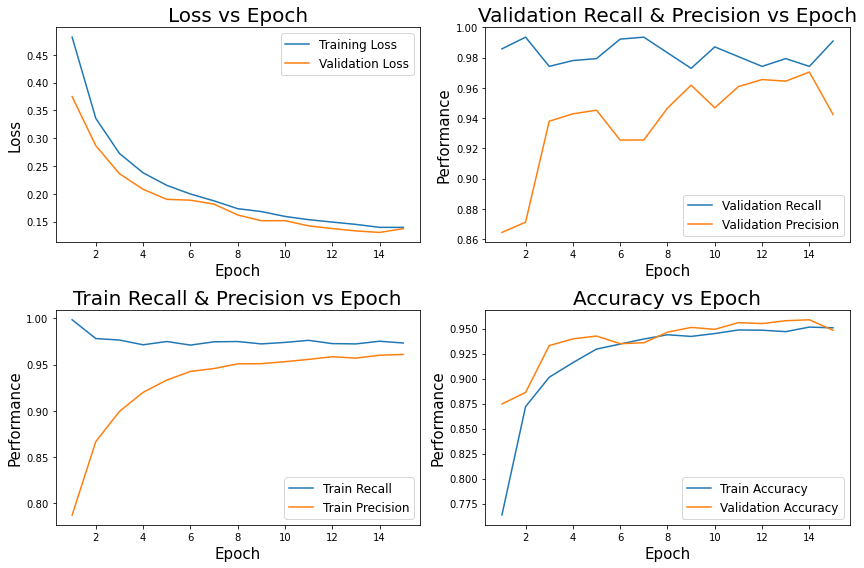

17/17 [==============================] - 7s 399ms/step - loss: 0.1371 - precision: 0.9424 - recall: 0.9910 - accuracy: 0.9483


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.137161,94.886893,98.551655,94.984478
1,Test,0.469800,75.787401,98.717946,79.487181
2,Validation,0.137147,94.240195,99.097937,94.832534


In [24]:
from functions import model_evaluate, train_model, view_history

#Train model
mlp['Version8'] = train_model(model_mlp_base_8, train_gen, val_gen, total_epochs=15)

# View history
view_history(mlp, "Version8")

# Evaluate model
model_evaluate(model_mlp_base_8, train_gen, test_gen, val_gen)

Its seems that Dense layers has reached its potential in feature extraction. Our loss metrics do not seem to be improving much. Our best performace was Version 6. Lets save tha model 

In [25]:
# Save Version 6 
model_directory = 'models/'

model_mlp_base_6.save(model_directory + 'mlpv6.keras')
model_mlp_base_8.save(model_directory + 'mlpv8.keras')

# Convolutional Neural Network


Based off our work from the MLP section Version 6 was our best model performance for loss and not overfitting. Now lets attempt to make a Convolutional Network. 

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import activations

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_1 = Sequential()

# Define our Conv layer to capture more global features by making Kernel size bigger
cnn_1.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_1.add(MaxPool2D(pool_size=(2,2), padding="same"))

# Define the Dense Layers
cnn_1.add(Flatten())
cnn_1.add(Dense(256, activation='relu', use_bias=True))

# Define output layer
cnn_1.add(Dense(1, activation='sigmoid'))


# Compile the model
cnn_1.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_1.summary())

ValueError: Unknown activation function: leaky_relu

Epoch 1/15
131/131 [==============================] - 153s 1s/step - loss: 4.0858 - precision: 0.9149 - recall: 0.8967 - accuracy: 0.8615 - val_loss: 0.1262 - val_precision: 0.9623 - val_recall: 0.9858 - val_accuracy: 0.9608
Epoch 2/15
131/131 [==============================] - 153s 1s/step - loss: 0.0498 - precision: 0.9881 - recall: 0.9868 - accuracy: 0.9814 - val_loss: 0.1036 - val_precision: 0.9722 - val_recall: 0.9923 - val_accuracy: 0.9732
Epoch 3/15
131/131 [==============================] - 152s 1s/step - loss: 0.0278 - precision: 0.9948 - recall: 0.9932 - accuracy: 0.9912 - val_loss: 0.1266 - val_precision: 0.9670 - val_recall: 0.9832 - val_accuracy: 0.9627
Epoch 4/15
131/131 [==============================] - ETA: 0s - loss: 0.0078 - precision: 0.9990 - recall: 0.9984 - accuracy: 0.9981
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
131/131 [==============================] - 153s 1s/step - loss: 0.0078 - precision: 0.9990 - recall: 0.9984 - a

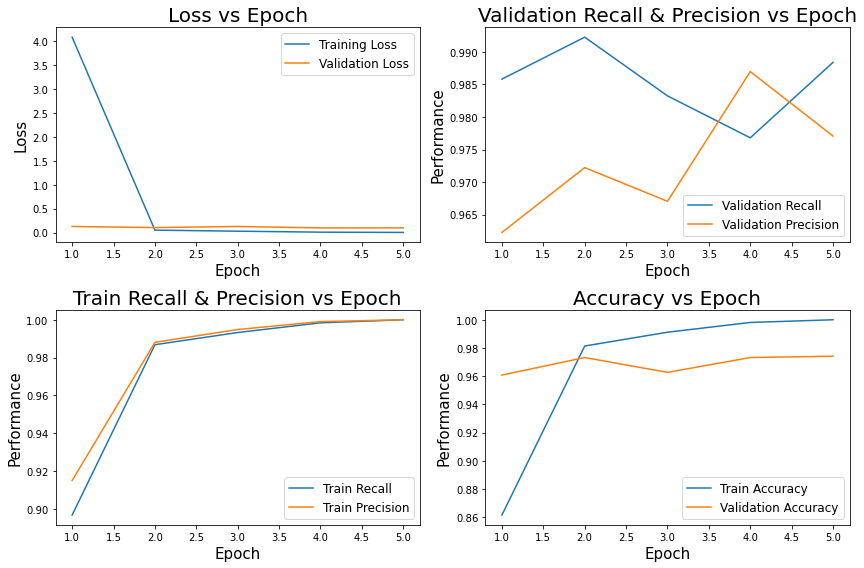

33/33 [==============================] - 10s 298ms/step - loss: 0.1036 - precision: 0.9722 - recall: 0.9923 - accuracy: 0.9732


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.014198,99.646872,99.903446,99.665630
1,Test,0.858112,75.680935,99.743587,79.807693
2,Validation,0.103571,97.222221,99.226803,97.320575


In [10]:
from functions import train_model, model_evaluate, view_history

cnn = {}

# Train model
cnn['Version1'] = train_model(cnn_1, train_gen, val_gen, 15)

# View history 
view_history(cnn, 'Version1')

# Evalaute model
model_evaluate(cnn_1, train_gen, test_gen, val_gen)

We can see we start to overfit but its quite difficlut to tell. Our train loss is lower than our val loss overall. We can try to increase the model depth

# CNN Version 2

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_2 = Sequential()

# Define a learning rate since we have an imabalnced dataset. Do not want the weights to favor the Pneumonia majority
lr = 0.000001

# Define the layers
# Define our Conv layer
cnn_2.add(Conv2D(filters=64, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_2.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_2.add(Flatten())

# Define our Dense Layers
cnn_2.add(Dense(256, activation='relu'))


# Define output layer
cnn_2.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_2.compile(optimizer=Adam(learning_rate=lr), loss=BinaryCrossentropy(apply_class_balancing=True), metrics=METRICS)
print(cnn_2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 1048576)           0         
_________________________________________________________________
dense (Dense)                (None, 256)               268435712 
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 268,440,833
Trainable params: 268,440,833
Non-trainable params: 0
_________________________________________________________________
None


In [11]:
from functions import train_model, model_evaluate, view_history

cnn = {}

# Train the model
cnn['Version2'] = train_model(cnn_2, train_gen, val_gen, 15)

# View History 
view_history(cnn, "Version2")

# Evalauate Model
model_evaluate(cnn_2, train_gen, test_gen, val_gen)

Epoch 1/15


ValueError: in user code:

    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\training.py:748 train_step
        loss = self.compiled_loss(
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:187 __call__
        self.build(y_pred)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:140 build
        self._losses = nest.map_structure(self._get_loss_object, self._losses)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\util\nest.py:635 map_structure
        structure[0], [func(*x) for x in entries],
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\util\nest.py:635 <listcomp>
        structure[0], [func(*x) for x in entries],
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:263 _get_loss_object
        loss = losses_mod.get(loss)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\losses.py:1895 get
        return deserialize(identifier)
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\losses.py:1850 deserialize
        return deserialize_keras_object(
    c:\Users\delga\anaconda3\envs\flatiron2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:377 deserialize_keras_object
        raise ValueError(

    ValueError: Unknown loss function: binaryfocalcrossentropy


The loss curves are still converging. We should more regularization. 

# CNN Version 3

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_3 = Sequential()

# Define the layers
# Define our Conv layer
cnn_3.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_3.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_3.add(Flatten())

# Define our Dense Layers
cnn_3.add(Dense(256, activation='relu'))

# Define output layer
cnn_3.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_3.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_3.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               67109120  
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 67,110,593
Trainable params: 67,110,593
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/15
66/66 [==============================] - 65s 986ms/step - loss: 0.5060 - precision: 0.7845 - recall: 0.9799 - accuracy: 0.7394 - val_loss: 0.4134 - val_precision: 0.7643 - val_recall: 0.9987 - val_accuracy: 0.7703
Epoch 2/15
66/66 [==============================] - 64s 972ms/step - loss: 0.3794 - precision: 0.8267 - recall: 0.9900 - accuracy: 0.8385 - val_loss: 0.3368 - val_precision: 0.8088 - val_recall: 0.9974 - val_accuracy: 0.8230
Epoch 3/15
66/66 [==============================] - 65s 989ms/step - loss: 0.3123 - precision: 0.8789 - recall: 0.9833 - accuracy: 0.8870 - val_loss: 0.2726 - val_precision: 0.9089 - val_recall: 0.9897 - val_accuracy: 0.9187
Epoch 4/15
66/66 [==============================] - 65s 980ms/step - loss: 0.2721 - precision: 0.9085 - recall: 0.9749 - accuracy: 0.9085 - val_loss: 0.2522 - val_precision: 0.8895 - val_recall: 0.9961 - val_accuracy: 0.9053
Epoch 5/15
66/66 [==============================] - 64s 963ms/step - loss: 0.2414 - precision: 0.920

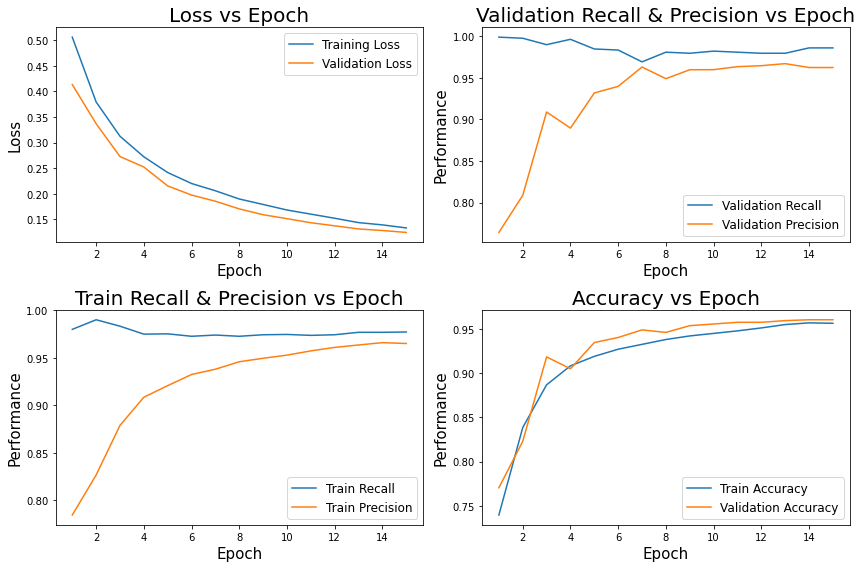

17/17 [==============================] - 7s 436ms/step - loss: 0.1243 - precision: 0.9623 - recall: 0.9858 - accuracy: 0.9608


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.129029,96.485120,98.068875,95.915931
1,Test,0.352551,79.835391,99.487180,83.974361
2,Validation,0.124306,96.226418,98.582476,96.076554


In [14]:
from functions import train_model, view_history, model_evaluate

# Train model
cnn['Version3'] = train_model(cnn_3, train_gen, val_gen, 15)

# Display history 
view_history(cnn, 'Version3')

# Evaluate Model
model_evaluate(cnn_3, train_gen, test_gen, val_gen)

It seems we are going to need more training time as our curve could have kept going. Besides this we can also see that the curve never diverged again. Since we have more information with our new ConV layer we should try adding more neurons and we can remove a max pool layer to introduce more spatial info for the dense layers

# CNN Version 4


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_4 = Sequential()

# Define the layers
# Define our Conv layer
cnn_4.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_4.add(MaxPool2D(pool_size=(2, 2), padding='same'))

# Flatten the input layer for the Dense layers
cnn_4.add(Flatten())

# Define our Dense Layers
cnn_4.add(Dense(196, activation='relu'))

# Define output layer
cnn_4.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_4.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_4.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 196)               51380420  
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 197       
Total params: 51,381,833
Trainable params: 51,381,833
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
66/66 [==============================] - 65s 992ms/step - loss: 0.5458 - precision: 0.7414 - recall: 0.9810 - accuracy: 0.7320 - val_loss: 0.4804 - val_precision: 0.7483 - val_recall: 1.0000 - val_accuracy: 0.7502
Epoch 2/25
66/66 [==============================] - 63s 958ms/step - loss: 0.4432 - precision: 0.7601 - recall: 0.9984 - accuracy: 0.7650 - val_loss: 0.3929 - val_precision: 0.8105 - val_recall: 0.9974 - val_accuracy: 0.8249
Epoch 3/25
66/66 [==============================] - 63s 952ms/step - loss: 0.3767 - precision: 0.8339 - recall: 0.9920 - accuracy: 0.8474 - val_loss: 0.3408 - val_precision: 0.8260 - val_recall: 0.9974 - val_accuracy: 0.8421
Epoch 4/25
66/66 [==============================] - 63s 960ms/step - loss: 0.3284 - precision: 0.8701 - recall: 0.9878 - accuracy: 0.8815 - val_loss: 0.2951 - val_precision: 0.8984 - val_recall: 0.9910 - val_accuracy: 0.9100
Epoch 5/25
66/66 [==============================] - 63s 958ms/step - loss: 0.2924 - precision: 0.895

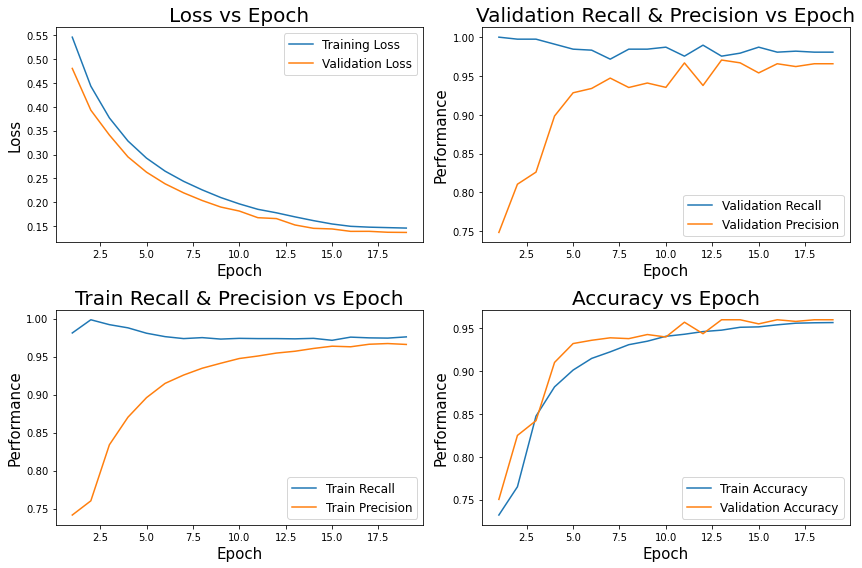

17/17 [==============================] - 7s 440ms/step - loss: 0.1390 - precision: 0.9657 - recall: 0.9807 - accuracy: 0.9598


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.148237,96.588010,97.489542,95.581561
1,Test,0.321134,81.645572,99.230766,85.576922
2,Validation,0.139021,96.573603,98.067009,95.980859


In [11]:
from functions import view_history, model_evaluate, train_model
# Train model
cnn = {}
cnn['Version4'] = train_model(cnn_4, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version4')

# Evaluate Model
model_evaluate(cnn_4, train_gen, test_gen, val_gen)

# CNN Version 5 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_5 = Sequential()

# Define the layers
# Define our Conv layer
cnn_5.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_5.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_5.add(Flatten())

# Define our Dense Layers
cnn_5.add(Dense(128, activation='relu'))

# Define output layer
cnn_5.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_5.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_5.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               33554560  
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 33,555,905
Trainable params: 33,555,905
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
66/66 [==============================] - 59s 890ms/step - loss: 0.5397 - precision: 0.7786 - recall: 0.9882 - accuracy: 0.7385 - val_loss: 0.4761 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 59s 892ms/step - loss: 0.4429 - precision: 0.7616 - recall: 0.9994 - accuracy: 0.7674 - val_loss: 0.3948 - val_precision: 0.8314 - val_recall: 0.9974 - val_accuracy: 0.8478
Epoch 3/25
66/66 [==============================] - 58s 883ms/step - loss: 0.3760 - precision: 0.8301 - recall: 0.9926 - accuracy: 0.8438 - val_loss: 0.3371 - val_precision: 0.8766 - val_recall: 0.9884 - val_accuracy: 0.8880
Epoch 4/25
66/66 [==============================] - 58s 880ms/step - loss: 0.3304 - precision: 0.8664 - recall: 0.9874 - accuracy: 0.8777 - val_loss: 0.2997 - val_precision: 0.8950 - val_recall: 0.9884 - val_accuracy: 0.9053
Epoch 5/25
66/66 [==============================] - 58s 885ms/step - loss: 0.2984 - precision: 0.893

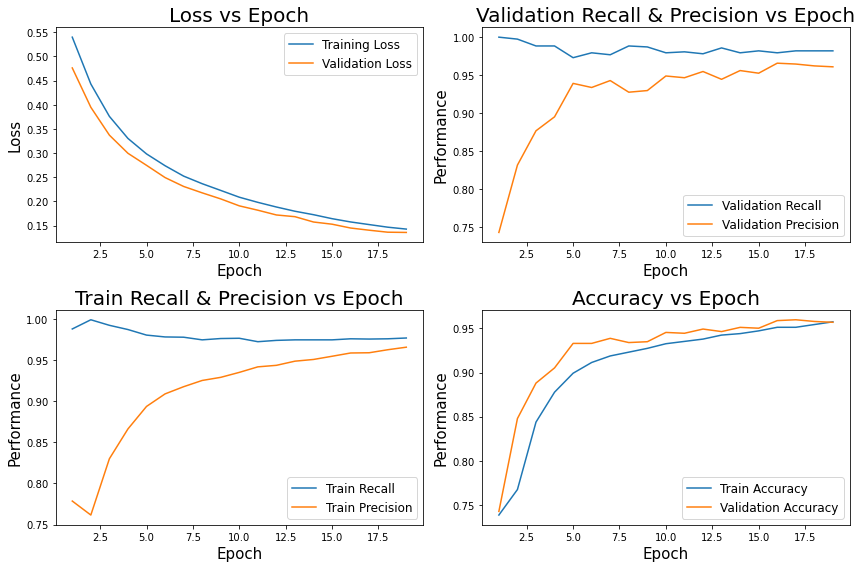

17/17 [==============================] - 7s 432ms/step - loss: 0.1451 - precision: 0.9657 - recall: 0.9794 - accuracy: 0.9589


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.154003,96.488988,97.296429,95.366609
1,Test,0.320984,82.127661,98.974359,85.897434
2,Validation,0.145143,96.569252,97.938144,95.885170


In [13]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version5'] = train_model(cnn_5, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version5')

# Evaluate Model
model_evaluate(cnn_5, train_gen, test_gen, val_gen)

This is good progress as our test loss is now .2 less than what it was. Adding more regularization is helping. Lets keep the same architecture but increase dropout 

# CNN Version 6

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_6 = Sequential()

# Define the layers
# Define our Conv layer
cnn_6.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_6.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_6.add(Flatten())

# Define our Dense Layers
cnn_6.add(Dense(64, activation='relu'))

# Define output layer
cnn_6.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_6.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_6.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16777280  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 16,778,561
Trainable params: 16,778,561
Non-trainable params: 0
_________________________________________________________________
None


Epoch 1/25
66/66 [==============================] - 56s 847ms/step - loss: 0.5354 - precision: 0.7774 - recall: 0.9959 - accuracy: 0.7421 - val_loss: 0.4815 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 55s 838ms/step - loss: 0.4465 - precision: 0.7649 - recall: 0.9977 - accuracy: 0.7707 - val_loss: 0.3998 - val_precision: 0.7971 - val_recall: 0.9974 - val_accuracy: 0.8096
Epoch 3/25
66/66 [==============================] - 55s 836ms/step - loss: 0.3822 - precision: 0.8176 - recall: 0.9942 - accuracy: 0.8311 - val_loss: 0.3478 - val_precision: 0.8395 - val_recall: 0.9974 - val_accuracy: 0.8565
Epoch 4/25
66/66 [==============================] - 56s 845ms/step - loss: 0.3395 - precision: 0.8639 - recall: 0.9871 - accuracy: 0.8751 - val_loss: 0.3080 - val_precision: 0.8910 - val_recall: 0.9897 - val_accuracy: 0.9024
Epoch 5/25
66/66 [==============================] - 55s 838ms/step - loss: 0.3051 - precision: 0.885

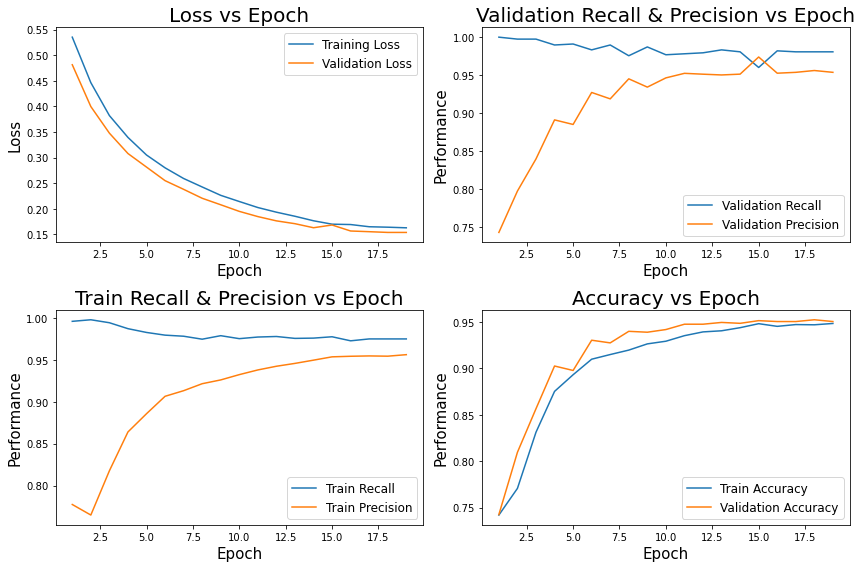

17/17 [==============================] - 7s 421ms/step - loss: 0.1566 - precision: 0.9525 - recall: 0.9820 - accuracy: 0.9502


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.165264,95.054775,97.747022,94.554573
1,Test,0.346983,79.835391,99.487180,83.974361
2,Validation,0.156588,95.249999,98.195875,95.023924


In [15]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version6'] = train_model(cnn_6, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version6')

# Evaluate Model
model_evaluate(cnn_6, train_gen, test_gen, val_gen)

We can see how we start to overfit with every epoch very slowly. To confirm lets just increase the information recieved by the dense layers by increase our filters since it is a little difficult to tell.

# CNN version 7

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_7 = Sequential()

# Define the layers
# Define our Conv layer
cnn_7.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_7.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_7.add(Flatten())

# Define our Dense Layers 
cnn_7.add(Dense(128, activation='relu'))
cnn_7.add(Dense(32, activation='relu'))

# Define output layer
cnn_7.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_7.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_7.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33554560  
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 33,559,937
Trainable params: 33,559,937
Non-trainable params: 0
____________________________________________

Epoch 1/25
66/66 [==============================] - 60s 916ms/step - loss: 0.5550 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.5135 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 59s 897ms/step - loss: 0.4796 - precision: 0.7449 - recall: 1.0000 - accuracy: 0.7459 - val_loss: 0.4320 - val_precision: 0.7591 - val_recall: 0.9987 - val_accuracy: 0.7636
Epoch 3/25
66/66 [==============================] - 59s 889ms/step - loss: 0.4118 - precision: 0.7913 - recall: 0.9971 - accuracy: 0.8027 - val_loss: 0.3760 - val_precision: 0.7922 - val_recall: 0.9974 - val_accuracy: 0.8038
Epoch 4/25
66/66 [==============================] - 59s 890ms/step - loss: 0.3617 - precision: 0.8445 - recall: 0.9897 - accuracy: 0.8572 - val_loss: 0.3291 - val_precision: 0.8632 - val_recall: 0.9923 - val_accuracy: 0.8775
Epoch 5/25
66/66 [==============================] - 59s 892ms/step - loss: 0.3248 - precision: 0.872

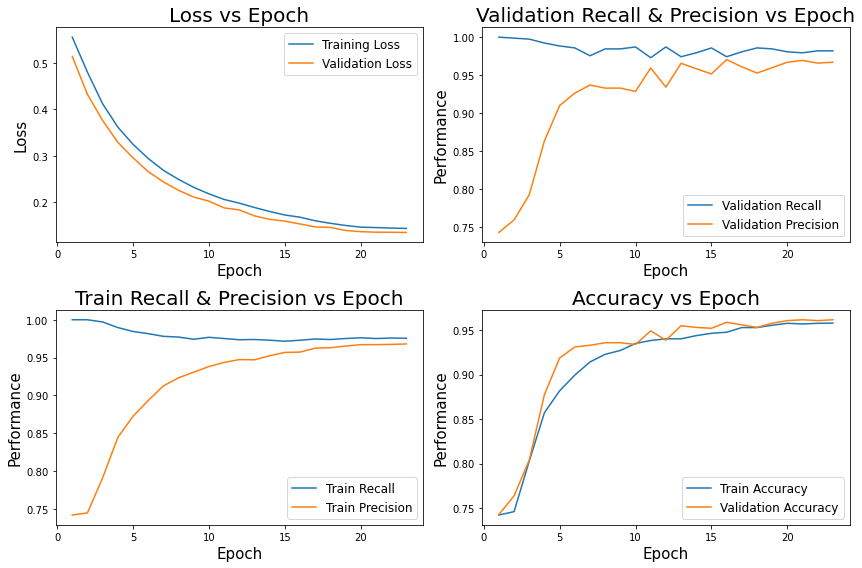

17/17 [==============================] - 7s 426ms/step - loss: 0.1371 - precision: 0.9670 - recall: 0.9807 - accuracy: 0.9608


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.145901,96.775222,97.553909,95.772630
1,Test,0.320008,81.512606,99.487180,85.576922
2,Validation,0.137140,96.696317,98.067009,96.076554


In [10]:
from functions import model_evaluate, train_model, view_history
cnn = {}

# Train model
cnn['Version7'] = train_model(cnn_7, train_gen, val_gen, 25)

# Display history 
view_history(cnn, 'Version7')

# Evaluate Model
model_evaluate(cnn_7, train_gen, test_gen, val_gen)

It seems that version 5 does better. We can attempt to generalize better by maybe adding more dense neurons to the first layer

# CNN Version 8

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn_8 = Sequential()

# Define the layers
# Define our Conv layer
cnn_8.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', padding='same', input_shape=input_shape))
cnn_8.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', padding='same'))
cnn_8.add(MaxPool2D())

# Flatten the input layer for the Dense layers
cnn_8.add(Flatten())

# Define our Dense Layers
cnn_8.add(Dense(128, activation='relu'))
cnn_8.add(Dense(32, activation='relu'))


# Define output layer
cnn_8.add(Dense(1, activation='sigmoid'))

# Compile the model
cnn_8.compile(optimizer=Adam(learning_rate=0.000001), loss=BinaryCrossentropy(), metrics=METRICS)
print(cnn_8.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               33554560  
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

Epoch 1/25
66/66 [==============================] - 102s 2s/step - loss: 0.5608 - precision: 0.7776 - recall: 0.9961 - accuracy: 0.7421 - val_loss: 0.5218 - val_precision: 0.7426 - val_recall: 1.0000 - val_accuracy: 0.7426
Epoch 2/25
66/66 [==============================] - 101s 2s/step - loss: 0.4953 - precision: 0.7421 - recall: 1.0000 - accuracy: 0.7421 - val_loss: 0.4554 - val_precision: 0.7454 - val_recall: 1.0000 - val_accuracy: 0.7464
Epoch 3/25
66/66 [==============================] - 102s 2s/step - loss: 0.4344 - precision: 0.7594 - recall: 0.9997 - accuracy: 0.7647 - val_loss: 0.3999 - val_precision: 0.7996 - val_recall: 0.9974 - val_accuracy: 0.8124
Epoch 4/25
66/66 [==============================] - 101s 2s/step - loss: 0.3907 - precision: 0.8170 - recall: 0.9942 - accuracy: 0.8304 - val_loss: 0.3600 - val_precision: 0.8190 - val_recall: 0.9974 - val_accuracy: 0.8344
Epoch 5/25
66/66 [==============================] - 102s 2s/step - loss: 0.3558 - precision: 0.8482 - recall

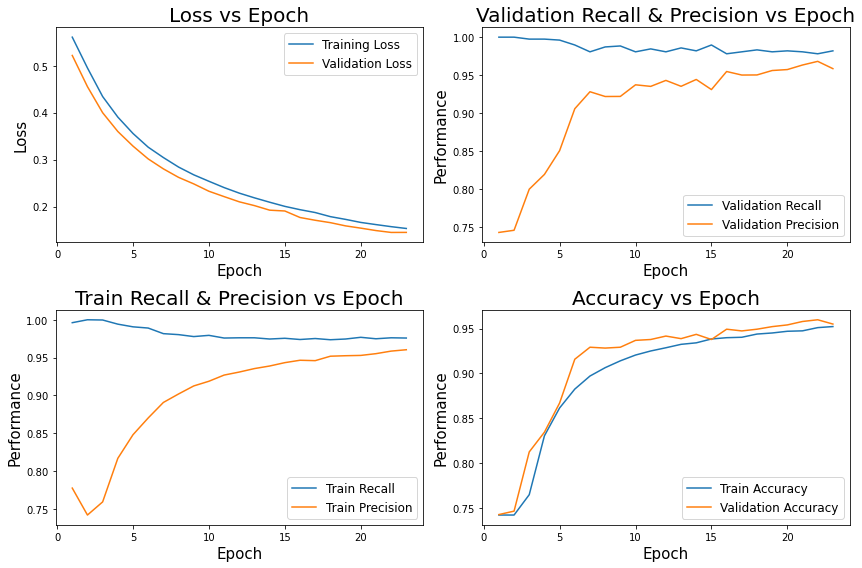

17/17 [==============================] - 8s 459ms/step - loss: 0.1543 - precision: 0.9573 - recall: 0.9820 - accuracy: 0.9541


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.163518,95.559055,97.650468,94.888943
1,Test,0.330712,81.171548,99.487180,85.256410
2,Validation,0.154301,95.728642,98.195875,95.406699


In [12]:
from functions import model_evaluate, train_model, view_history

# Train model
cnn['Version 8'] = train_model(cnn_8, train_gen, val_gen, 25)

# View History 
view_history(cnn, 'Version 8')

# Evaluate model
model_evaluate(cnn_8, train_gen, test_gen, val_gen)

I would say adding more neurons actually did not give any performance gain at all. This is where we should do data augmentation using Version 5

In [25]:
cnn_5.save("models/cnn5.keras")

In [26]:
cnn_5.save("models/cnn5control.keras")

# Data Augmentation

I made a function that augments our data and normalizes the data for training. Lets retrive our new data generators. 

In [34]:
# Call data augmentation fucntion
from functions import data_augmentation

train_gen_aug, test_gen_aug, val_gen_aug = data_augmentation(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 3934 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1298 images belonging to 2 classes.


Now that we have our data generators we can proceed to continue training our cnn10 & cnn 11 models with data augmentation

In [28]:
from tensorflow.keras.models import load_model

model_1 = load_model("models/cnn5.keras")

Epoch 1/15
123/123 [==============================] - 126s 1s/step - loss: 0.6548 - precision: 0.6930 - recall: 0.9430 - accuracy: 0.6718 - val_loss: 0.4647 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 2/15
123/123 [==============================] - 121s 986ms/step - loss: 0.6209 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4554 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 3/15
123/123 [==============================] - 126s 1s/step - loss: 0.6200 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4468 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 4/15
123/123 [==============================] - 123s 999ms/step - loss: 0.6188 - precision: 0.6912 - recall: 1.0000 - accuracy: 0.6912 - val_loss: 0.4417 - val_precision: 0.8968 - val_recall: 1.0000 - val_accuracy: 0.8968
Epoch 5/15
123/123 [==============================] - 121s 982ms/step - loss: 0.6186 - precisi

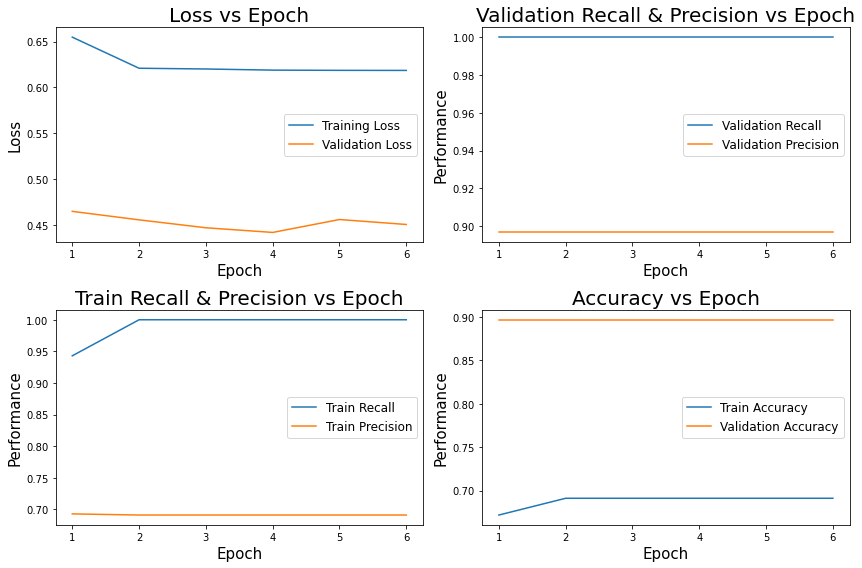

41/41 [==============================] - 14s 337ms/step - loss: 0.4468 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618868,69.115406,100.0,69.115406
1,Test,0.674243,62.500000,100.0,62.500000
2,Validation,0.446760,89.676428,100.0,89.676428


In [29]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model1 = {}

# Train the model
cnn_aug_model1['Version1'] = train_model(model_1, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model1, 'Version1')

# Evaluate model
model_evaluate(model_1, train_gen_aug, test_gen_aug, val_gen_aug)

In [30]:
# Evaluate model
model_evaluate(model_1, train_gen, test_gen, val_gen)

41/41 [==============================] - 14s 329ms/step - loss: 0.4468 - precision: 0.8968 - recall: 1.0000 - accuracy: 0.8968


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.618868,69.115406,100.0,69.115406
1,Test,0.674243,62.500000,100.0,62.500000
2,Validation,0.446760,89.676428,100.0,89.676428


In [33]:
# Save our model from augmented training
model_1.save("models/cnn5_aug.keras")

Our losses in our test are much better. Every loss decreases suggetsing that the model is learning better. Unfortunartly our metrics did not improve by much however this model version is much more reliable then the pervious non augmented version

# Transfer Learning

Another method to use here would be to use an already pre trained network and see the results with our network

In [35]:
# Initialize Base
from keras.applications import VGG19
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.models import Sequential
from keras.regularizers import l2

# Define input shape
input_shape = (256, 256, 3)

# Load in the pretrained CNN
cnn_base_vgg = VGG19(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
    )

# Make configuration
model_pre = Sequential()
model_pre.add(cnn_base_vgg)
model_pre.add(Flatten())

# Define the same dense layers with our best cnn version that I made 
# Define our Dense Layers
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))
model_pre.add(Dense(64, activation='relu'))
model_pre.add(Dropout(.2, seed=42))
model_pre.add(Dense(64, activation='relu', kernel_regularizer=l2(0.1)))

# Define output layer
model_pre.add(Dense(1, activation='sigmoid'))

# Define the pretrained model as an exclusion from changing its weights
cnn_base_vgg.trainable = False

model_pre.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=METRICS)
print(model_pre.summary())

80142336/80134624 [==============================] - 2s 0us/step
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 8, 8, 512)         20024384  
_________________________________________________________________
flatten_8 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 64)                2097216   
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_39 (Dense)             (None, 64)                4160      
_______________________________________________________

Epoch 1/15
123/123 [==============================] - 422s 3s/step - loss: 6.7044 - precision: 0.8949 - recall: 0.9209 - accuracy: 0.8208 - val_loss: 2.5334 - val_precision: 0.9942 - val_recall: 0.8840 - val_accuracy: 0.8914
Epoch 2/15
123/123 [==============================] - 415s 3s/step - loss: 1.3153 - precision: 0.9202 - recall: 0.9033 - accuracy: 0.8790 - val_loss: 0.4619 - val_precision: 0.9605 - val_recall: 0.9811 - val_accuracy: 0.9468
Epoch 3/15
123/123 [==============================] - 416s 3s/step - loss: 0.4165 - precision: 0.9413 - recall: 0.9139 - accuracy: 0.9011 - val_loss: 0.2893 - val_precision: 0.9981 - val_recall: 0.8918 - val_accuracy: 0.9014
Epoch 4/15
123/123 [==============================] - 416s 3s/step - loss: 0.2781 - precision: 0.9429 - recall: 0.9235 - accuracy: 0.9085 - val_loss: 0.1307 - val_precision: 0.9895 - val_recall: 0.9708 - val_accuracy: 0.9646
Epoch 5/15
123/123 [==============================] - 418s 3s/step - loss: 0.2589 - precision: 0.942

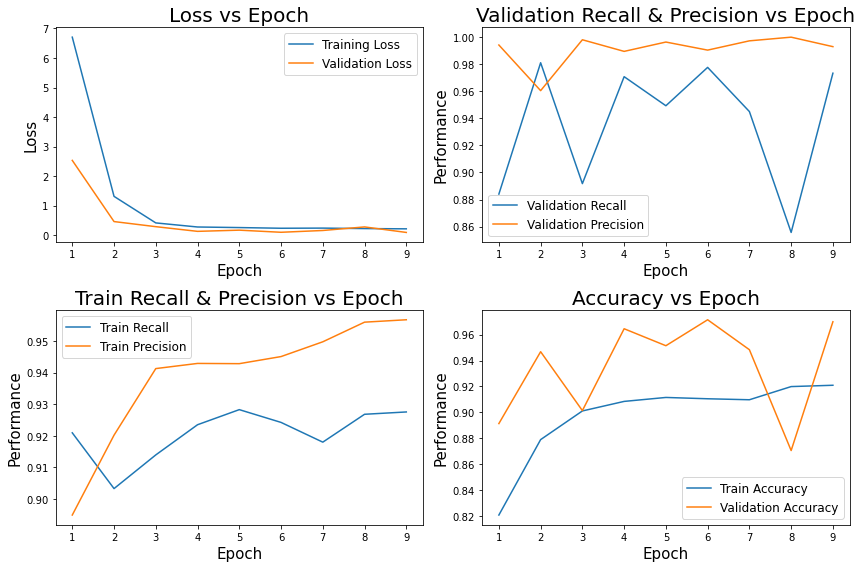

41/41 [==============================] - 101s 2s/step - loss: 0.0994 - precision: 0.9904 - recall: 0.9777 - accuracy: 0.9715


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.216484,91.911513,97.793305,92.526692
1,Test,0.347788,84.279478,98.974359,87.820512
2,Validation,0.099401,99.042648,97.766322,97.149462


In [36]:
from functions import model_evaluate, view_history, train_model
cnn_aug_model2 = {}

# Train the model
cnn_aug_model2['Version1'] = train_model(model_pre, train_gen_aug, val_gen_aug, 15)

# Visualize history 
view_history(cnn_aug_model2, 'Version1')

# Evaluate model
model_evaluate(model_pre, train_gen_aug, test_gen_aug, val_gen_aug)

In [37]:
model_pre.save("models/cnnpre.keras")

Using the pretrained architecture we see how our loss are similar acorss the board. We perform better using the VGG19 according to our metrics. Our model version does not perform as great as the pretrained conv network. The final evaluation should be using the VGG19 network. 